In [61]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from pop_tools import get_grid

In [2]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

Create a client with 36 cores (full node of CPUs), and 36 workers. I.e. each parallel process uses one CPU core.

In [3]:
cluster = NCARCluster(cores=36, memory="100GB", walltime="00:30:00", processes=36)
# Gets 5 nodes worth of these workers.
cluster.scale(36*5)

In [5]:
client = Client(cluster)

Below should show what port your dashboard is sent to. You can click the dask tab on the left (the orange icon) and type `/proxy/#####` where the ###'s is the port. It defaults to 8787 but if someone else is using that it will give you a random port. Press enter and the buttons should light up orange. I drag "workers" and "task stream" over to the right side to see the workers computing.

In [8]:
client

Client Scheduler: tcp://10.12.205.30:41452 Dashboard: https://jupyterhub.ucar.edu/dav/user/rbrady/proxy/8787/status,Cluster Workers: 144 Cores: 144 Memory: 400.32 GB


Load in example SST output.

In [10]:
filepath = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/SST/'

This ignores member `001` since it's 1850-2005, and I'm not worried about the future scenarios for this example.

In [16]:
ds = xr.open_mfdataset(filepath + 'b.e11.B20TRC5CNBDRD.f09_g16.*.pop.h.SST.192001-200512.nc',
                       concat_dim='member',
                       parallel=True,
                       combine='nested',
                       coords='minimal',
                       compat='override'
                       )

In [17]:
ds = ds['SST'].squeeze()

In [32]:
# Fix time
ds['time'] = np.arange('1920-01', '2006-01', dtype='datetime64[M]')

In [19]:
print(ds)

<xarray.DataArray 'SST' (member: 41, time: 1032, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(41, 1032, 384, 320), dtype=float32, chunksize=(1, 1032, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    z_t      float32 500.0
  * time     (time) object 1920-02-01 00:00:00 ... 2006-01-01 00:00:00
Dimensions without coordinates: member, nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean


Check the chunk size. We might want to rechunk to make the chunks ~100MB each for efficiency.

In [22]:
ds.data

,Array,Chunk
Bytes,20.80 GB,507.25 MB
Shape,"(41, 1032, 384, 320)","(1, 1032, 384, 320)"
Count,205 Tasks,41 Chunks
Type,float32,numpy.ndarray


In [27]:
ds = ds.chunk({'member': 1, 'time': -1, 'nlat': -1, 'nlon': 50})

In [30]:
ds.data

,Array,Chunk
Bytes,20.80 GB,79.26 MB
Shape,"(41, 1032, 384, 320)","(1, 1032, 384, 50)"
Count,1066 Tasks,287 Chunks
Type,float32,numpy.ndarray


Compute spread in SST in ensemble.

In [44]:
grid = get_grid('POP_gx1v7')
area = grid['TAREA']

In [50]:
mask = ds.isel(member=0, time=0).notnull()

In [51]:
# Mask area with continents
area = area.where(mask)

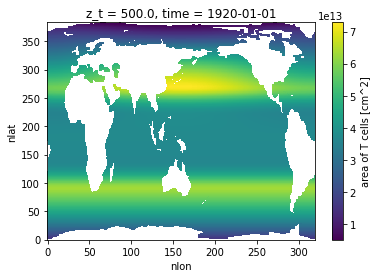

In [53]:
area.plot()

In [54]:
# Just going to take a global average so we can plot it.
global_mean = (ds * area).sum(['nlat', 'nlon']) / area.sum(['nlat', 'nlon'])

In [56]:
# Need to do `.compute()` since we're using dask and it is out of memory
global_mean = global_mean.compute()

That wild streak is an error in one of the ensemble members. It doesn't really matter here.

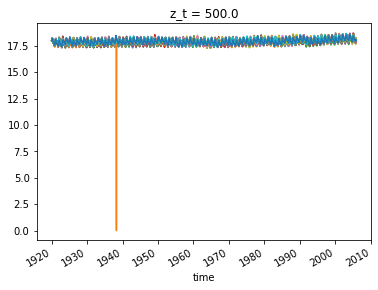

In [68]:
global_mean.plot(hue='member', add_legend=False)
plt.show()

Well, we should get rid of it.

In [82]:
# Can do this more robustly with some sigma thing but it's clear what to do here.
global_mean = global_mean.where( (global_mean > 15) )

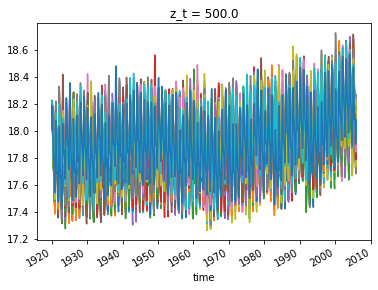

In [83]:
global_mean.plot(hue='member', add_legend=False)
plt.show()

In [84]:
# Variance across members
variance = global_mean.var('member')

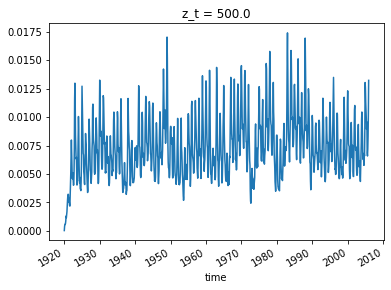

In [85]:
variance.plot()

In [86]:
# Standard deviation
standard_dev = global_mean.std('member')

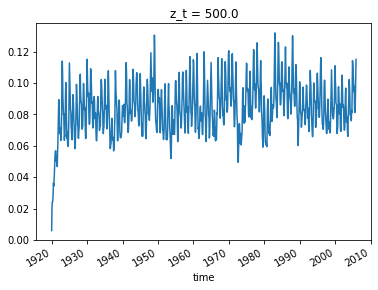

In [87]:
standard_dev.plot()

## Compute slopes

In [88]:
def _compute_slope(y):
    """
    Private function to compute slopes at each grid cell using
    polyfit. 
    """
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0] # return only the slope

def compute_slope(da):
    """
    Computes linear slope (m) at each grid cell.
    
    Args:
      da: xarray DataArray to compute slopes for
      
    Returns:
      xarray DataArray with slopes computed at each grid cell.
    """
    # apply_ufunc can apply a raw numpy function to a grid.
    # 
    # vectorize is only needed for functions that aren't already
    # vectorized. You don't need it for polyfit in theory, but it's
    # good to use when using things like np.cov. I'm using it here so
    # that it just passes in one grid cell at a time to _compute_slope.
    #
    # dask='parallelized' parallelizes this across dask chunks. It requires
    # an output_dtypes of the numpy array datatype coming out.
    #
    # input_core_dims should pass the dimension that is being *reduced* by this operation,
    # if one is being reduced.
    slopes = xr.apply_ufunc(_compute_slope,
                            da,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes

In [90]:
# Switch to annual means to make things a little easier.
ds = ds.groupby('time.year').mean('time')
ds = ds.rename({'year': 'time'})

/glade/work/rbrady/miniconda3/envs/carbonpathways/lib/python3.8/site-packages/xarray/core/common.py:671: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  return self._groupby_cls(


Nuanced, but you need to make the time chunk over the full time dimension (`-1` keyword) since we are applying this function over the time dimension.

In [97]:
ds = ds.chunk({'time': -1})

In [98]:
result = compute_slope(ds)

Now the below is going to

In [101]:
%time result = result.compute()

CPU times: user 49.9 s, sys: 17.2 s, total: 1min 7s
Wall time: 1min 22s


Trend in degC per year globally for different ensemble members.

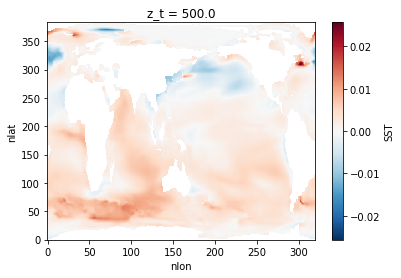

In [105]:
result.isel(member=0).plot()

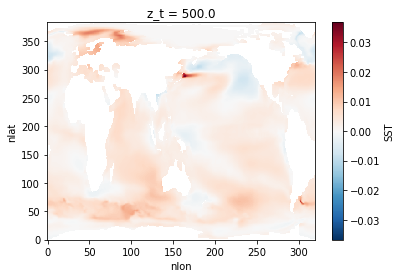

In [106]:
result.isel(member=1).plot()

Compute forced signal (ensemble mean trend). 

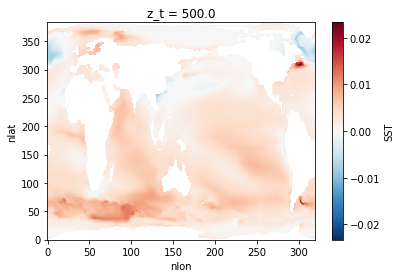

In [110]:
result.mean('member').plot()

Compute spread in trends (noise).

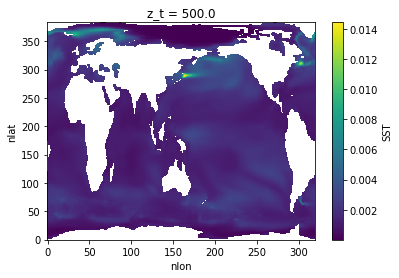

In [111]:
result.std('member').plot()

You can of course subset to just the Southern Ocean, or regions of the Southern Ocean and take area-weighted averages then calculate the trend.